In [11]:
import pandas as pd
import numpy as np
import nltk
import pyprind
import wordcloud

In [2]:
df = pd.read_csv('data/TWT_Data1.csv')

In [12]:
df.shape
df.isnull().sum()

Person ID    0
Message      0
Sentiment    0
dtype: int64

In [13]:
df.head()

,Person ID,Message,Sentiment
0,1,I followed those and was not offered to speak ...,Neutral
1,2,"Hi, I paid my payment 2 days ago and would be ...",Negative
2,3,I just gotta let the world know. @CreditOneBan...,Negative
3,4,@NASCARSW42 @KyleLarsonRacin @CreditOneBank @c...,Positive
4,5,@NASCARSW42 @kyleLarsonRacin @CreditOneBank @c...,Negative


In [23]:
import re
def preprocessor(text):
    text = re.sub('<[^>]*>', '', text)
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text)
    text = (re.sub('[\W]+', ' ', text.lower()) + ' '.join(emoticons).replace('-', ''))
    text = text.replace('â', '')
    return text

In [24]:
# Run the preprocessor on just one sentence
print(df.loc[10, 'Message'][0:])
preprocessor(df.loc[10, 'Message'][0:])

 creditonebank my card still hasn t shown up in the mail it s been 9 days or so since being approved


' creditonebank my card still hasn t shown up in the mail it s been 9 days or so since being approved'

In [25]:
# Run the preprocessor on the entire dataset
df['Message'] = df['Message'].apply(preprocessor) 

In [26]:
df['Message'].head(20)

0     i followed those and was not offered to speak ...
1     hi i paid my payment 2 days ago and would be c...
2     i just gotta let the world know creditonebank ...
3      nascarsw42 kylelarsonracin creditonebank clov...
4      nascarsw42 kylelarsonracin creditonebank clov...
5     checkered flag joshparker81 brings the no 42 c...
6      nascarsw42 kylelarsonracin creditonebgnk clov...
7     i called to complain about my card i tried to ...
8                ch cocacolaracing creditonebank nascar
9     https twitter com johnpaysor status 1159533290...
10     creditonebank my card still hasn t shown up i...
11       try calling me again didn t not recognize the 
12    hi my card still hasn t shown up in the mail i...
13                                   creditonebank sent
14    thank you for your help the explanation made t...
15     creditonebank your website needs to get it to...
16     cards2p kylelarsonracin creditonebank cgrteam...
17         how do i speak directly to a represen

In [28]:
from nltk.stem.porter import PorterStemmer
porter = PorterStemmer()

def tokenizer(text):
    return text.split()

# Porter stemming (just get the root word for all of the words)
def tokenizer_porter(text):
    return [porter.stem(word) for word in text.split()] 

# Tokenize everything and do the stemming
from nltk.corpus import stopwords
stop = stopwords.words('english')
[w for w in tokenizer_porter('creditonebank my card still hasn t shown up in the mail it s been 9 days or so since being approved')[0:] if w not in stop] 

['creditonebank',
 'card',
 'still',
 'shown',
 'mail',
 '9',
 'day',
 'sinc',
 'approv']

In [29]:
from sklearn.feature_extraction.text import CountVectorizer

count = CountVectorizer()
docs = np.array(df['Message'])
bag = count.fit_transform(docs) 

print(count.vocabulary_) 
bag.shape

{'followed': 492, 'those': 1209, 'and': 109, 'was': 1314, 'not': 837, 'offered': 856, 'to': 1225, 'speak': 1107, 'with': 1349, 'rep': 997, 'what': 1328, 'number': 846, 'on': 863, 'the': 1194, 'prompts': 944, 'should': 1074, 'select': 1053, 'hi': 588, 'paid': 888, 'my': 804, 'payment': 897, 'days': 357, 'ago': 83, 'would': 1364, 'be': 180, 'considered': 314, 'as': 139, 'even': 437, 'it': 654, 'due': 406, 'date': 354, 'for': 493, 'credit': 331, 'card': 244, 'an': 108, 'example': 447, 'just': 665, 'gotta': 551, 'let': 700, 'world': 1360, 'know': 673, 'creditonebank': 335, 'is': 649, 'worst': 1362, 'financial': 483, 'institution': 637, 'in': 619, 'america': 104, 'hate': 571, 'them': 1197, 'so': 1096, 'much': 799, 'nascarsw42': 812, 'kylelarsonracin': 678, 'clovercommerce': 288, 'adventhealth': 77, 'mcdonalds': 759, 'its': 655, 'car': 243, 'you': 1380, 'won': 1352, 'allstar': 92, 'race': 966, 'whichever': 1335, 'scheme': 1039, 'he': 575, 'wins': 1347, 'points': 919, 've': 1294, 'tried': 124

(311, 1386)

In [31]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf = TfidfTransformer(use_idf=True, norm='l2', smooth_idf=True)
print(tfidf.fit_transform(count.fit_transform(docs)).toarray()) 

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [34]:
X_train = df.loc[:200, 'Message'].values
y_train = df.loc[:200, 'Sentiment'].values
X_test = df.loc[200:, 'Message'].values
y_test = df.loc[200:, 'Sentiment'].values 


In [35]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV 

tfidf = TfidfVectorizer(
    strip_accents=None,
    lowercase=False,
    preprocessor=None,
)

param_grid = [
    {
        'vect__ngram_range': [(1, 1)],
        'vect__stop_words': [stop, None],
        'vect__tokenizer': [tokenizer, tokenizer_porter],
        'clf__penalty': ['l1', 'l2'],
        'clf__C': [1.0, 10.0, 100.0],
    }, {
        'vect__ngram_range': [(1, 1)],
        'vect__stop_words': [stop, None],
        'vect__tokenizer': [tokenizer, tokenizer_porter],
        'vect__use_idf': [False],
        'vect__norm':[None],
        'clf__penalty': ['l1', 'l2'],
        'clf__C': [1.0, 10.0, 100.0],
    },
] 



lr_tfidf = Pipeline(
    [
        ('vect', tfidf), (
            'clf',
            LogisticRegression(random_state=0),
        ),
    ],
)

gs_lr_tfidf = GridSearchCV(
    lr_tfidf,
    param_grid,
    scoring='accuracy',
    cv=5,
    verbose=1,
    n_jobs=-1,
) 


gs_lr_tfidf.fit(X_train, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:    4.9s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('vect',
                                        TfidfVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=False,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                                        n

In [36]:
gs_lr_tfidf.fit(X_train, y_train) 
print('Best parameter set: %s ' % gs_lr_tfidf.best_params_)
print('CV Accuracy: %.3f' % gs_lr_tfidf.best_score_) 

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:    1.9s


Best parameter set: {'clf__C': 10.0, 'clf__penalty': 'l2', 'vect__ngram_range': (1, 1), 'vect__norm': None, 'vect__stop_words': None, 'vect__tokenizer': <function tokenizer at 0x7f615ef80c20>, 'vect__use_idf': False} 
CV Accuracy: 0.712


[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:    3.9s finished


In [38]:
clf = gs_lr_tfidf.best_estimator_
print('Test Accuracy: %.3f' % clf.score(X_test, y_test)) 

Test Accuracy: 0.712


i followed those and was not offered to speak with a rep what number on the prompts should i select  hi i paid my payment 2 days ago and would be considered as a payment even my it s not my due date for my credit card as an example  i just gotta let the world know creditonebank is the worst financial institution in america i hate them so much    nascarsw42 kylelarsonracin creditonebank clovercommerce adventhealth mcdonalds adventhealth its the car you won the allstar race in   nascarsw42 kylelarsonracin creditonebank clovercommerce adventhealth mcdonalds whichever scheme he wins a points race in i ve tried literally the same thing happens no matter what number i call for credit one bank  checkered flag joshparker81 brings the no 42 creditonebank chevy home in 1 th enascarheat p42ker  nascarsw42 kylelarsonracin creditonebgnk clovercommerce adventhealth mcdonalds mcdonalds i called to complain about my card i tried to make a payment on aug 1 and it would not let me said nothing was due t

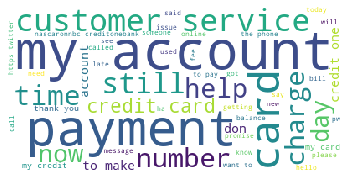

In [40]:
import matplotlib.pyplot as plt
%matplotlib inline
from wordcloud import WordCloud, STOPWORDS 
# Combine all Messages for the desired sentiment
combined_text = " ".join([review for review in df['Message']]) 
print(combined_text) 
# Initialize wordcloud object
wc = WordCloud(
    background_color='white',
    max_words=50,
    # update stopwords to include common words like the, in, was.....
    stopwords = STOPWORDS.update(['the','in','was','my','creditonebank','hi']))

# Generate and plot wordcloud
plt.imshow(wc.generate(combined_text))
plt.axis('off')
plt.show() 
